# Food Image Classification (Food101 Dataset)

## Problem Statement

Food logging and dietary analysis are important tools for individuals and healthcare professionals to monitor and manage nutrition and health. However, manually logging food intake can be time-consuming and error-prone, leading to inaccurate analysis and suboptimal outcomes. Recent advances in computer vision and deep learning have opened up new opportunities to automate the process of food logging by using image classification techniques to identify and categorize different types of food items based on their visual features.


Therefore, the goal of this project is to develop an image classification model that can identify various types of food items from images. This model is trained on the Food101 dataset (https://www.kaggle.com/datasets/kmader/food41), that consists of 101 categories of dishes such as beignets, Chicken Wings, Chocolate Mousse, Falafel, Macaroni And Cheese among others. The dataset includes over 1000 images for each category. The models use prominent image classification transformers such as ResNet50 and EfficientNet, data augmentation techniques and transfomer tweaking to learn from the visual features of the images, such as color, texture, shape, and context, to accurately classify the food items.

### Future Scope

The resulting food image classification model can be integrated into a mobile or web-based application, where users can take pictures of their meals, and the application can automatically identify and log the food items, along with their nutritional information. This can greatly improve the efficiency and accuracy of food logging and dietary analysis, helping individuals make better-informed food choices and healthcare professionals to provide more personalized and effective nutritional advice.

## Dataset

The dataset for this problem is taken from the following link: https://www.kaggle.com/datasets/kmader/food41. As the name Food101 suggests, the dataset contains 101 categories of food dishes including various dishes from contemporary dishes like Peking Duck, Foie Gras, Fillet Mignon, Eggs Benedict, Hot Dogs, Lobster Bisque to traditional dishes like Greek Salad, Guacamole, Hummus, Pho, Sashimi, Sushi etc. The dataset contains 1000 images for each food category, that totals to 101k images. The dataset was populated by FoodSpotting. 

## Code

### Importing packages

In [2]:
import tensorflow as tf                                                 # TensorFlow
from tensorflow import keras as k                                       # Keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator     # ImageDataGenerator: Generate batches of tensor image data with real-time data augmentation.
import tensorflow.keras.layers as layers                                # keras.layers: Used to import various layers for building neural networks such as Flatten, Dense, Conv2D etc.
from tensorflow.keras.models import Sequential                          # models.Sequential: Used to create a sequential model i.e. A neural network model with plain stack of layers.
import matplotlib.pyplot as plt                                         # PyPlot: Used to plot the functions and graphs i.e. Accuracy and Loss curves.
import tensorflow_hub as hub                                            # Tensorflow Hub: Used to download and load pretrained models.

c:\Users\gupta\anaconda3\envs\virtualenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Helper function to plot accuracy and loss curves

In [ ]:
def plot_result_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    Args:
      history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

### Preparing data

We initialize the ImageDataGenerator object with rescale 1./255 and validation split of 0.2.

**Rescale**: Converts the pixels in range [0,255] to range [0,1]. This process is also called Normalizing the input. Scaling every images to the same range [0,1] will make images contributes more evenly to the total loss and removes bias from the model.

**Validation split** : The images are split into 80% training and 20% validation images

In [5]:
datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

In [6]:
train_data = datagen.flow_from_directory('input/', target_size = (250,250), batch_size = 32, class_mode = 'categorical',
                                        subset = 'training') # Creating the training dataset

val_data = datagen.flow_from_directory('input/', target_size = (250,250), batch_size = 32, class_mode = 'categorical',
                                        subset = 'validation') # Creating the validation dataset

Found 80800 images belonging to 101 classes.
Found 20200 images belonging to 101 classes.


We have separated 80,800 images for the training set and 20,200 images for the validation set, totaling upto 101,000 images.

### Model Building

#### Model 1: ResNet50 V2

ResNet50 is a deep convolutional neural network architecture that was introduced by Microsoft researchers in 2015. The name "ResNet" stands for "Residual Network" and refers to the use of residual connections, which allow for easier training of very deep neural networks.

The ResNet50 architecture consists of 50 layers, including a combination of convolutional, pooling, and fully connected layers. It is based on the concept of residual learning, where each block of layers contains a shortcut connection that adds the input of the block to its output. This allows the network to learn residual functions, i.e., the difference between the input and the output, rather than trying to directly learn the desired output.

In [30]:
ResNet_V2_50 = 'https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5' # Declaring the path to the model.

In this model, we are using the ResNetV2 model from TensorFlow hub. The trainable parameter of the ResNetV2 model is set to False, so that the weigts and biases of the models remain fixed while training.

We get the output of the ResNetV2 model in the final Dense layer with 101 neurons, representing the number of classes in the dataset. It uses the softmax activation function since this is a multiclass classification problem.

### Testing ResNet50 with data

To compare the performance of CNN at different stages, we test the performance of the original (un-tuned) ResNet50 model on the Food101 dataset. Later, we will compare the test accuracy of the final model.

In [50]:
model_ResNet_test = tf.keras.Sequential([
    hub.KerasLayer(ResNet_V2_50, trainable = False, input_shape = (64,64,3), name = 'Resnet_V2_50'), # ResNet_V2_50 Layer
    tf.keras.layers.Dense(101, activation = 'softmax', name = 'Output_layer')                        # Dense layer for final output
])

model_ResNet_test.compile(
    optimizer = tf.keras.optimizers.Adam(),           # Adam optimizer with learning rate 0.001
    loss = tf.keras.losses.CategoricalCrossentropy(), # Categorical crossentropy loss: Since the output label is assigned one-hot category encoding value in form of 0s and 1.
    metrics = ['accuracy']                            # Accuracy metric to be used for model evaluation
)

model_ResNet_test.summary()

model_ResNet_test.evaluate(train_data)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Resnet_V2_50 (KerasLayer)   (None, 1001)              25615849  
                                                                 
 Output_layer (Dense)        (None, 101)               101202    
                                                                 
Total params: 25,717,051
Trainable params: 101,202
Non-trainable params: 25,615,849
_________________________________________________________________
2525/2525 [==============================] - 194s 76ms/step - loss: 6.6045 - accuracy: 0.0114


[6.604486465454102, 0.011386138387024403]

We observe that the accuracy of the untuned ResNet_V2_50 Model is only 1% which is understandable since the model was originally trained for open domain rather than a specialized subset of data.

### Fine-tuning ResNet CNN Model

In [7]:
model_ResNet = tf.keras.Sequential([
    hub.KerasLayer(ResNet_V2_50, trainable = False, input_shape = (64,64,3), name = 'Resnet_V2_50'), # ResNet_V2_50 Layer
    tf.keras.layers.Dense(101, activation = 'softmax', name = 'Output_layer')                        # Dense layer for final output
])

model_ResNet.compile(
    optimizer = tf.keras.optimizers.Adam(),           # Adam optimizer with learning rate 0.001
    loss = tf.keras.losses.CategoricalCrossentropy(), # Categorical crossentropy loss: Since the output label is assigned one-hot category encoding value in form of 0s and 1.
    metrics = ['accuracy']                            # Accuracy metric to be used for model evaluation
)

In [33]:
model_ResNet.summary() # Printing the model summary

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Resnet_V2_50 (KerasLayer)   (None, 1001)              25615849  
                                                                 
 Output_layer (Dense)        (None, 101)               101202    
                                                                 
Total params: 25,717,051
Trainable params: 101,202
Non-trainable params: 25,615,849
_________________________________________________________________


In [10]:
resnet_model_history = model_ResNet.fit(train_data, validation_data=val_data, epochs=15, verbose=1) # Training the model

Epoch 1/15
2525/2525 [==============================] - 213s 83ms/step - loss: 2.2306 - accuracy: 0.4679 - val_loss: 2.0085 - val_accuracy: 0.5173
Epoch 2/15
2525/2525 [==============================] - 220s 87ms/step - loss: 1.8576 - accuracy: 0.5467 - val_loss: 1.9610 - val_accuracy: 0.5336
Epoch 3/15
2525/2525 [==============================] - 216s 86ms/step - loss: 1.7523 - accuracy: 0.5695 - val_loss: 1.9849 - val_accuracy: 0.5360
Epoch 4/15
2525/2525 [==============================] - 208s 82ms/step - loss: 1.6844 - accuracy: 0.5808 - val_loss: 2.0047 - val_accuracy: 0.5372
Epoch 5/15
2525/2525 [==============================] - 207s 82ms/step - loss: 1.6355 - accuracy: 0.5924 - val_loss: 2.0605 - val_accuracy: 0.5305
Epoch 6/15
2525/2525 [==============================] - 210s 83ms/step - loss: 1.6006 - accuracy: 0.5992 - val_loss: 2.0177 - val_accuracy: 0.5403
Epoch 7/15
2525/2525 [==============================] - 211s 84ms/step - loss: 1.5679 - accuracy: 0.6075 - val_loss: 2

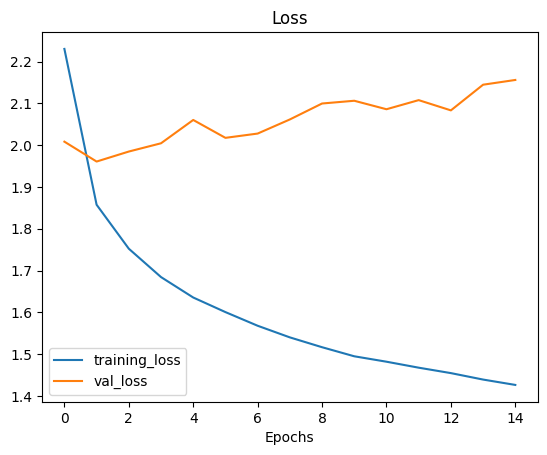

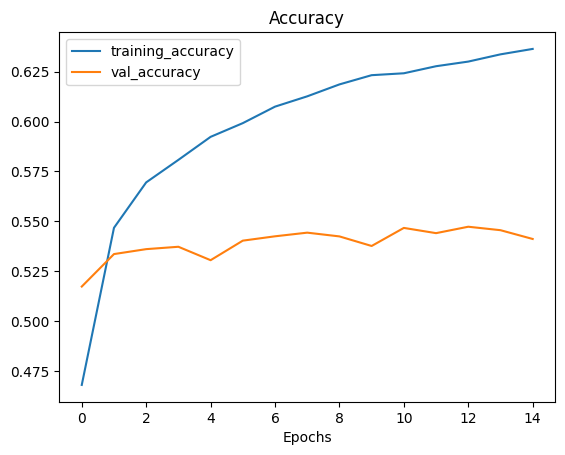

In [11]:
plot_result_curves(resnet_model_history)

In [12]:
model_ResNet.save('models/resnet50.h5')

Model 1 gives out a best training accuracy of 0.6364 i.e. 63.64% and the best validation accuracy of 0.5411 i.e. 54.11%. I am sure we can do better than that.

### Model 2: EfficientNet-B0

### EfficientNet

EfficientNet is a deep convolutional neural network architecture that was introduced by Google researchers in 2019. The name "EfficientNet" refers to the fact that it achieves state-of-the-art performance on a variety of computer vision tasks while being more computationally efficient than previous models.

EfficientNet is based on a novel approach to neural architecture search, which involves optimizing the scaling of the model's width, depth, and resolution to achieve better performance. Specifically, the researchers used a compound scaling method, where they systematically increased the width, depth, and resolution of the base network while keeping the number of parameters and FLOPs (floating-point operations) constant.

In [35]:
EfficientNet = "https://tfhub.dev/google/efficientnet/b0/classification/1" # Declaring the path for the EfficientNet model

In this model, we are using the EfficientNet model from TensorFlow hub. The trainable parameter of the EfficientNet model is set to False, so that the weigts and biases of the models remain fixed while training.

We get the output of the EfficientNet model in the final Dense layer with 101 neurons, representing the number of classes in the dataset, same as model 1.

In [52]:
model_Efficientnet_test = tf.keras.Sequential([
    hub.KerasLayer(EfficientNet, trainable = False, input_shape = (64,64,3), name = 'Resnet_V2_50'), # ResNet_V2_50 Layer
    tf.keras.layers.Dense(101, activation = 'softmax', name = 'Output_layer')                        # Dense layer for final output
])

model_Efficientnet_test.compile(
    optimizer = tf.keras.optimizers.Adam(),           # Adam optimizer with learning rate 0.001
    loss = tf.keras.losses.CategoricalCrossentropy(), # Categorical crossentropy loss: Since the output label is assigned one-hot category encoding value in form of 0s and 1.
    metrics = ['accuracy']                            # Accuracy metric to be used for model evaluation
)

model_Efficientnet_test.summary()

model_Efficientnet_test.evaluate(train_data)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Resnet_V2_50 (KerasLayer)   (None, 1000)              5330564   
                                                                 
 Output_layer (Dense)        (None, 101)               101101    
                                                                 
Total params: 5,431,665
Trainable params: 101,101
Non-trainable params: 5,330,564
_________________________________________________________________
2525/2525 [==============================] - 155s 61ms/step - loss: 5.4985 - accuracy: 0.0094


[5.498457431793213, 0.009405940771102905]

Untuned EfficientNet-B0 model only gives out 0.94% accuracy on the Food101 dataset.

### Fine-tuning the EfficientNet-B0 model

In [14]:
model_Efficientnet = tf.keras.Sequential([
    hub.KerasLayer(EfficientNet, trainable = False, input_shape = (250,250,3), name = 'EfficientNet_B0'), # EfficientNet_B0 Layer
    tf.keras.layers.Dense(101, activation = 'softmax', name = 'Output_layer')                             # Dense layer for output
])

model_Efficientnet.compile(
    optimizer = tf.keras.optimizers.Adam(),           # Adam optimizer with learning rate 0.001
    loss = tf.keras.losses.CategoricalCrossentropy(), # Categorical crossentropy loss: Since the output label is assigned one-hot category encoding value in form of 0s and 1.
    metrics = ['accuracy']                            # Accuracy metric to be used for model evaluation
)

In [ ]:
model_Efficientnet.summary() # Printing the model summary

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EfficientNet_B0 (KerasLayer  (None, 1000)             5330564   
 )                                                               
                                                                 
 Output_layer (Dense)        (None, 101)               101101    
                                                                 
Total params: 5,431,665
Trainable params: 101,101
Non-trainable params: 5,330,564
_________________________________________________________________


In [16]:
efficientnet_model_history = model_Efficientnet.fit(train_data, validation_data=val_data, epochs = 15, verbose = 1) # Training the model

Epoch 1/15
2525/2525 [==============================] - 213s 84ms/step - loss: 1.6398 - accuracy: 0.5858 - val_loss: 1.3879 - val_accuracy: 0.6511
Epoch 2/15
2525/2525 [==============================] - 207s 82ms/step - loss: 1.2604 - accuracy: 0.6737 - val_loss: 1.3860 - val_accuracy: 0.6570
Epoch 3/15
2525/2525 [==============================] - 205s 81ms/step - loss: 1.1622 - accuracy: 0.6957 - val_loss: 1.3976 - val_accuracy: 0.6578
Epoch 4/15
2525/2525 [==============================] - 186s 74ms/step - loss: 1.0987 - accuracy: 0.7089 - val_loss: 1.3939 - val_accuracy: 0.6638
Epoch 5/15
2525/2525 [==============================] - 175s 69ms/step - loss: 1.0545 - accuracy: 0.7206 - val_loss: 1.4069 - val_accuracy: 0.6610
Epoch 6/15
2525/2525 [==============================] - 172s 68ms/step - loss: 1.0186 - accuracy: 0.7261 - val_loss: 1.4231 - val_accuracy: 0.6649
Epoch 7/15
2525/2525 [==============================] - 175s 69ms/step - loss: 0.9875 - accuracy: 0.7330 - val_loss: 1

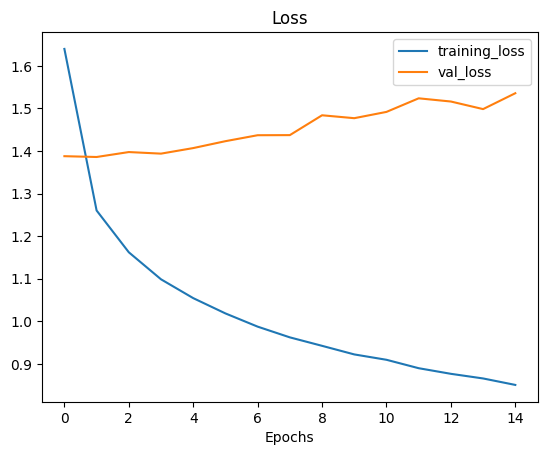

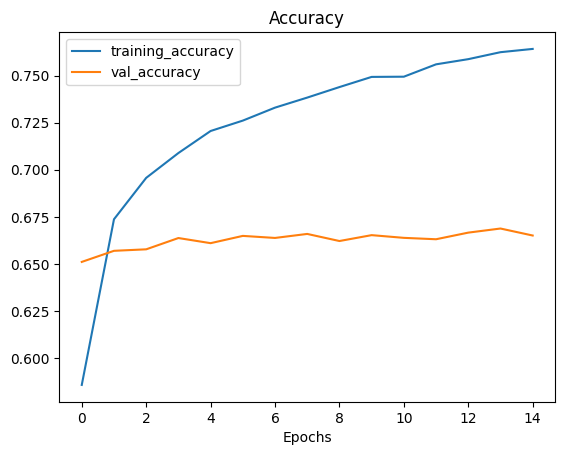

In [17]:
plot_result_curves(efficientnet_model_history)

Model 2 gives out a best training accuracy of 0.7641 i.e. 76.41% and the best validation accuracy of 0.6651 i.e. 66.51%. As we can see, the EfficientNet-B0 model performs much better than the ResNet50 model for our problem.

In [18]:
model_Efficientnet.save('models/EfficientNet_B0.h5')

### Model 3: EfficientNet-B0 model with Data Augmentation

### Data Augmentation

Data augmentation is a technique used to increase the size and diversity of a training dataset for image classification problems. It involves applying a variety of image transformations to the original images, resulting in new images that are similar but not identical to the original ones. The purpose of data augmentation is to increase the robustness and generalization capability of a machine learning model by exposing it to a wider variety of input data. Data Augmentation helps improve the generalization ability of a machine learning model.

These are the techniques used for Data Augmentation in this project:

1. RandomRotation: We use the factor of 0.2 to define the maximum rotation angle i.e. 0.2 * 2pi = 0.2 * 360 = 72 degrees. Therefore, the range of rotation angle will vary from -72 degrees to 72 degrees.
2. RandomZoom: We use the factor of 0.2 to define the zoom range i.e. Zoomed in by 20% or Zoomed out by 20%.
3. RandomHeight: We use the factor of 0.2 to define the range of height i.e. from 120% to 80% of the original image height.
4. RandomWidth: We use the factor of 0.2 to define the range of width i.e. from 120% to 80% of the original image width.
5. RandomFlip: We use the factor horizontal instead of horizontal_and_vertical since adding a vertical flip might make an image unnatural, and since most of the images received by the model for testing would not be vertically inverted.

In [19]:
data_augmentation = Sequential([
    layers.RandomRotation(0.2),      # RandomRotation: A preprocessing layer which randomly rotates images during training.
    layers.RandomZoom(0.2),          # RandomZoom:     A preprocessing layer which randomly zooms images during training.
    layers.RandomHeight(0.2),        # RandomHeight:   A preprocessing layer which randomly changes the height of images during training.
    layers.RandomWidth(0.2),         # RandomWidth:    A preprocessing layer which randomly changes the width of images during training.
    layers.RandomFlip("horizontal"), # RandomFlip:     A preprocessing layer which randomly flips images during training.
], name="data_augmentation") # Defining the data augmentation layer

### Fine-tuning the EfficientNet-B0 model with Data Augmentation

In [20]:
model_Efficientnet_DA = tf.keras.Sequential([
    layers.Input(shape=(250, 250, 3), name="input_layer"),                     # Input layer with shape (250, 250, 3)
    data_augmentation,                                                         # Data augmentation layer with image transformations
    hub.KerasLayer(EfficientNet, trainable = False, name = 'Efficientnet_b0'), # EfficientNet model layer with fixed weights and biases
    layers.Flatten(name="flatten"),                                            # Flatten layer
    tf.keras.layers.Dense(101, activation = 'softmax', name = 'Output_layer')  # Output layer with 101 neurons
])

In [21]:
model_Efficientnet_DA.compile(loss="categorical_crossentropy",         # Categorical crossentropy loss: Since the output label is assigned one-hot category encoding value in form of 0s and 1.
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),          # Adam optimizer with learning rate 0.0001
    metrics=["accuracy"])                                              # Accuracy metric to be used for model evaluation

In [22]:
model_Efficientnet_DA.summary() # Printing the model summary

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 Efficientnet_b0 (KerasLayer  (None, 1000)             5330564   
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 Output_layer (Dense)        (None, 101)               101101    
                                                                 
Total params: 5,431,665
Trainable params: 101,101
Non-trainable params: 5,330,564
_________________________________________________________________


In [23]:
model_Efficientnet_DA_Hist = model_Efficientnet_DA.fit(train_data, validation_data=val_data, epochs=15) # Training the model

Epoch 1/15


2525/2525 [==============================] - 391s 153ms/step - loss: 2.9794 - accuracy: 0.3200 - val_loss: 2.0385 - val_accuracy: 0.4920
Epoch 2/15
2525/2525 [==============================] - 379s 150ms/step - loss: 2.0364 - accuracy: 0.4983 - val_loss: 1.7392 - val_accuracy: 0.5588
Epoch 3/15
2525/2525 [==============================] - 380s 151ms/step - loss: 1.8456 - accuracy: 0.5365 - val_loss: 1.6301 - val_accuracy: 0.5842
Epoch 4/15
2525/2525 [==============================] - 381s 151ms/step - loss: 1.7450 - accuracy: 0.5585 - val_loss: 1.5637 - val_accuracy: 0.5997
Epoch 5/15
2525/2525 [==============================] - 380s 150ms/step - loss: 1.6868 - accuracy: 0.5709 - val_loss: 1.5316 - val_accuracy: 0.6043
Epoch 6/15
2525/2525 [==============================] - 385s 152ms/step - loss: 1.6321 - accuracy: 0.5822 - val_loss: 1.5043 - val_accuracy: 0.6117
Epoch 7/15
2525/2525 [==============================] - 386s 153ms/step - loss: 1.5955 - accuracy: 0.5927 - val_loss: 1.470

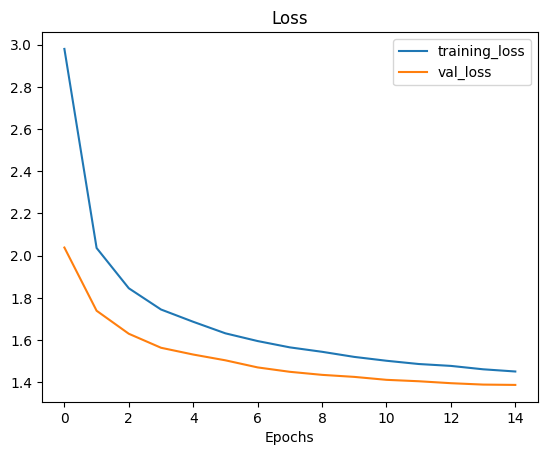

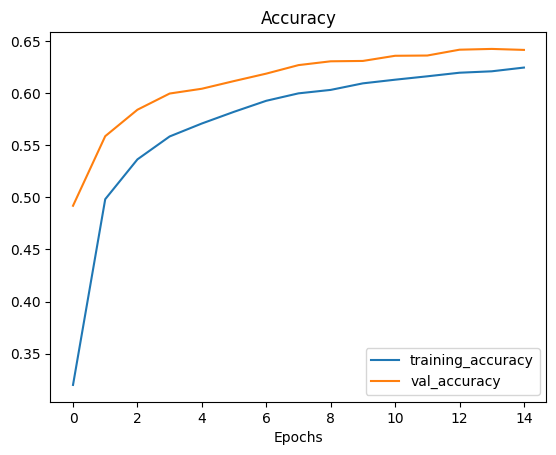

In [24]:
plot_result_curves(model_Efficientnet_DA_Hist) # Plotting the result curves

Model 3 gives out a best training accuracy of 0.6246  i.e. 62.46% and the best validation accuracy of 0.6416 i.e. 64.16%. Although this model has not resulted in a better training accuracy as compared to Model 2, it is still a good model to use since it has been trained for transformed images. Therefore, this model is more general as comapared to Model 2.

### Model 4: EfficientNet_B0 Model with 5 trainable layers

We set some layers as trainable during fine-tuning so as to balance the trade-off between leveraging the pre-trained model's knowledge and adapting it to the new task or dataset. By freezing some layers, we can preserve the pre-trained model's ability to extract general features and patterns from the input data, which can be transferred to the new task or dataset.

In [17]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # Setting all the layers to non-trainable

for layer in base_model.layers[:-5]:
    layer.trainable = True # Setting last 5 layers to trainable

inputs = layers.Input(shape=(250, 250, 3), name="input_layer")            # Input layer with shape (250, 250, 3)
x = base_model(inputs)                                                    # EfficientNetB0 model layer with last 5 layers as trainable
x = layers.Flatten()(x)                                                   # Flatten layer
outputs = layers.Dense(101, activation="softmax", name="output_layer")(x) # Final output layer with 101 neurons

model = tf.keras.Model(inputs, outputs) # Building the model

In [18]:
model.compile(loss="categorical_crossentropy",                         # Categorical crossentropy loss: Since the output label is assigned one-hot category encoding value in form of 0s and 1.
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # Adam optimizer with learning rate 0.0001
             metrics=["accuracy"])                                     # Accuracy metric to be used for model evaluation

In [19]:
model.summary() # Printing the model summary

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 250, 250, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 output_layer (Dense)        (None, 101)               6334821   
                                                                 
Total params: 10,384,392
Trainable params: 6,334,821
Non-trainable params: 4,049,571
_________________________________________________________________


In [20]:
model_history = model.fit(train_data, validation_data=val_data, epochs=15) # Training the model

Epoch 1/15
2525/2525 [==============================] - 225s 88ms/step - loss: 3.3990 - accuracy: 0.3449 - val_loss: 3.1565 - val_accuracy: 0.4275
Epoch 2/15
2525/2525 [==============================] - 211s 84ms/step - loss: 1.3765 - accuracy: 0.6672 - val_loss: 3.4041 - val_accuracy: 0.4251
Epoch 3/15
2525/2525 [==============================] - 211s 84ms/step - loss: 0.8021 - accuracy: 0.7877 - val_loss: 3.7787 - val_accuracy: 0.4232
Epoch 4/15
2525/2525 [==============================] - 217s 86ms/step - loss: 0.6061 - accuracy: 0.8346 - val_loss: 4.0999 - val_accuracy: 0.4238
Epoch 5/15
2525/2525 [==============================] - 257s 102ms/step - loss: 0.4909 - accuracy: 0.8676 - val_loss: 4.3967 - val_accuracy: 0.4257
Epoch 6/15
2525/2525 [==============================] - 252s 100ms/step - loss: 0.4322 - accuracy: 0.8854 - val_loss: 4.6385 - val_accuracy: 0.4264
Epoch 7/15
2525/2525 [==============================] - 261s 103ms/step - loss: 0.3848 - accuracy: 0.8984 - val_loss

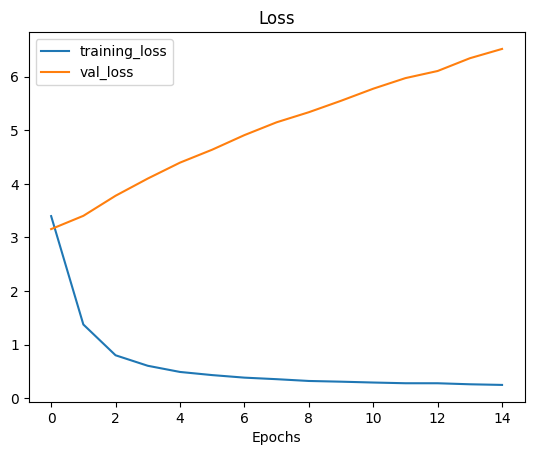

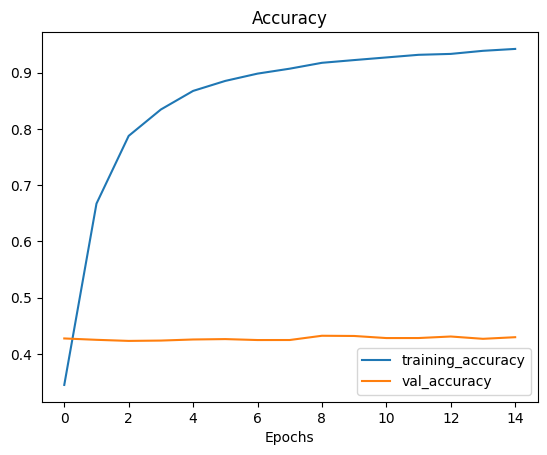

In [23]:
plot_result_curves(model_history) # Plotting the result curves

Model 4 gives out a best training accuracy of 0.9423  i.e. 94.23% and the best validation accuracy of 0.4298 i.e. 42.98%. This model has resulted in a far better training accuracy. This means that the model is well trained on the training data. However, the validation accuracy is not as good as the training accuracy. It indicates that we have run into severe overfitting, where the model is not able to make a good prediction on the validation data.

### Model 5: EfficientNet-B0 Model with 2 trainable layers

In this model, we experiment with only the last two layers of the EfficientNet model as trainable.

In [24]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # Setting all the layers to non-trainable

for layer in base_model.layers[:-2]:
    layer.trainable = True # Setting last 2 layers to trainable

inputs = layers.Input(shape=(250, 250, 3), name="input_layer")            # Input layer with shape (250, 250, 3)
x = base_model(inputs)                                                    # EfficientNetB0 model layer with last 2 layers as trainable
x = layers.Flatten()(x)                                                   # Flatten layer
outputs = layers.Dense(101, activation="softmax", name="output_layer")(x) # Final output layer with 101 neurons

model = tf.keras.Model(inputs, outputs) # Building the model

In [25]:
model.compile(loss="categorical_crossentropy",                         # Categorical crossentropy loss: Since the output label is assigned one-hot category encoding value in form of 0s and 1.
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # Adam optimizer with learning rate 0.0001
             metrics=["accuracy"])                                     # Accuracy metric to be used for model evaluation

model.summary() # Printing the model summary

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 250, 250, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 flatten_2 (Flatten)         (None, 62720)             0         
                                                                 
 output_layer (Dense)        (None, 101)               6334821   
                                                                 
Total params: 10,384,392
Trainable params: 6,334,821
Non-trainable params: 4,049,571
_________________________________________________________________


In [26]:
model_history_2 = model.fit(train_data, validation_data=val_data, epochs=15) # Training the model

Epoch 1/15
2525/2525 [==============================] - 269s 105ms/step - loss: 3.2169 - accuracy: 0.3395 - val_loss: 2.9019 - val_accuracy: 0.4260
Epoch 2/15
2525/2525 [==============================] - 231s 91ms/step - loss: 1.1069 - accuracy: 0.7130 - val_loss: 3.1421 - val_accuracy: 0.4176
Epoch 3/15
2525/2525 [==============================] - 227s 90ms/step - loss: 0.5848 - accuracy: 0.8361 - val_loss: 3.4429 - val_accuracy: 0.4169
Epoch 4/15
2525/2525 [==============================] - 230s 91ms/step - loss: 0.4284 - accuracy: 0.8782 - val_loss: 3.7559 - val_accuracy: 0.4150
Epoch 5/15
2525/2525 [==============================] - 243s 96ms/step - loss: 0.3440 - accuracy: 0.9014 - val_loss: 4.0374 - val_accuracy: 0.4173
Epoch 6/15
2525/2525 [==============================] - 240s 95ms/step - loss: 0.2993 - accuracy: 0.9155 - val_loss: 4.2260 - val_accuracy: 0.4138
Epoch 7/15
2525/2525 [==============================] - 227s 90ms/step - loss: 0.2833 - accuracy: 0.9217 - val_loss: 

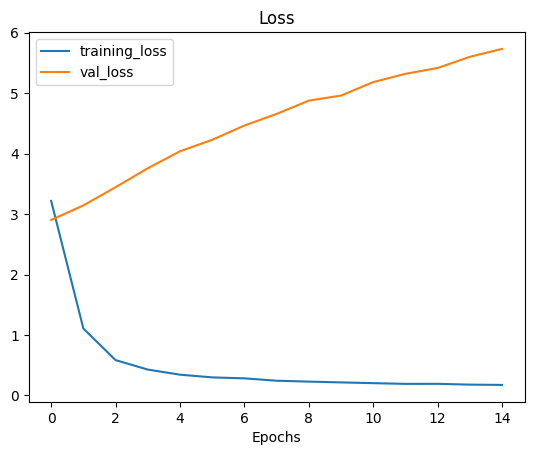

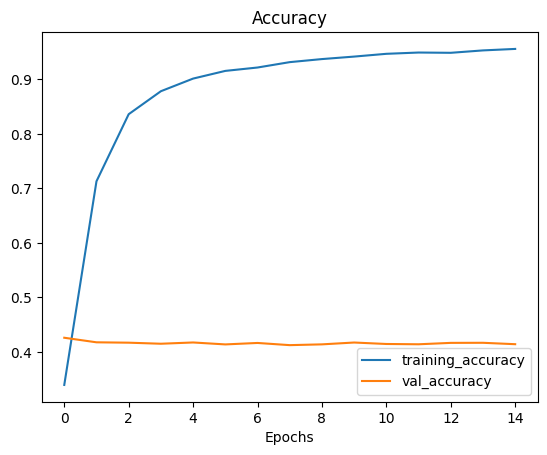

In [27]:
plot_result_curves(model_history_2) # Plotting the result curves

Model 5 gives out a best training accuracy of 0.9423  i.e. 94.23% and the best validation accuracy of 0.4298 i.e. 42.98%. This shows that although keeping the final layers as trainable results in higher accuracy, the model is still not performing well on the validation set.

### Comparison

In [41]:
model.evaluate(val_data)

632/632 [==============================] - 46s 72ms/step - loss: 5.7289 - accuracy: 0.4142


[5.7289252281188965, 0.4141584038734436]

#### We observe here that although the testing accuracy is not very good, the fine-tuned EfficientNet Model still performs very well as compared to the original untuned model.

## Conclusion

Following are the training and validation accuracies of the trained models

| Model   | Description                             | Training Accuracy | Validation Accuracy |
|---------|-----------------------------------------|-------------------|---------------------|
| Model 1 | ResNet-50                               | 63.64%            | 54.11%              |
| Model 2 | EfficientNet_B0                         | 76.41%            | 66.51%              |
| Model 3 | EfficientNet_B0 with Data Augmentation  | 62.46%            | 64.16%              |
| Model 4 | EfficientNet_B0 with 5 trainable layers | 94.23%            | 42.98%              |
| Model 5 | EfficientNet_B0 with 2 trainable layers | 95.58%            | 41.42%              |

We can conclude from here that EfficientNet_B0 is the most generally efficient model so far, since it has a good training accuracy and the best performance on the test set. However, it also indicates that setting last layers of the model to trainable can be useful for fine-tuning, considering we use measures to prevent overfitting. We can use techniques such as: Early Stopping, Dropout, or Weight Decay to prevent these situations from occurring.